
(tutorials-phonon)=

# Phonon band structure of Si

In this tutorial you will learn how to calculate the phonon band structure of silicon step by step using `aiida-vibroscopy`.

In this tutorial we will make use of the silicon structure to give you an overall understanding of the usage of the package.
If you are interested in more advanced features, please have a look at the [other tutorials](tutorials).

Let's get started!


## Frozen phonons

In the harmonic and Born-Oppenheimer approximation, phonons are defined as second order derivatives of the potential energy surface (PES).
These derivatives can be evaluated numerically around the equilibrium point $ \{ \mathbf{R}_0 \} $ (i.e. relaxed ions) displacing the atoms along the three Cartesian directions. The second derivatives become first derivatives when using forces, and one can use the following formula:

\begin{equation}
\left .
\frac{\partial f(x)}{\partial x}
\right |_{x=0}
\approx 
\frac{1}{2h} 
(f(h)-f(-h))
+ \mathcal{O}(h^2)
\end{equation} 

The $h$ is then the finite displacement of the atom from the relaxed position. Usually, good values are 0.01-0.005 Å. The default in the package is 0.01 Å.

This technique of computing the force constants matrix is usually referred to as __frozen phonons__ (or also __small displacements__).

:::{note}
One should verify that the phonon frequencies do not change within the desired threshold when change the value of $h$.
:::

In [1]:
from local_module import load_temp_profile

# If you download this file, you can run it with your own profile.
# Put these lines instead:
# from aiida import load_profile
# load_profile()
data = load_temp_profile(
    name="phonon-tutorial",
    add_computer=True,
    add_pw_code=True,
    add_phonopy_code=True,
    add_sssp=True,
)

### Importing the structure from COD

Let's import the silicon structure from the COD database via AiiDA.

In [2]:
from aiida.plugins import DbImporterFactory

CodDbImporter = DbImporterFactory('cod')

cod = CodDbImporter()
results = cod.query(id='1526655') # Si   1526655
structure = results[0].get_aiida_structure() # it has 8 atoms


## The `PhononWorkChain`

To compute the phonons, then one need to displace all the (non equivalent by symmetry) atoms along the (non equivalent by symmetry) Cartesian directions. As phonons are related to collective ionic motions, this methods needs __supercells__ in order to account for patterns that live outside the unitcell.

:::{note}
:class: dropdown

Not all patterns can be computed using the frozen phonon approach, as too large supercells would be required. An implementation that would make this possible is the __linear response__ method (DFPT). Usually this is a more efficient approach, but its implementation is non-trivial and involved, hence only few codes have this method implemented. Quantum ESPRESSO can carry out such simulations using the __PHonon__ code (`ph.x` routine). Nevertheless, not all functionals are implemented. For example, DFT+U(+V) using ortho-atomic projectors is not implemented.
:::

Let's import the WorkChain and run it! We use the `get_builder_from_protocol` to get a __prefilled__ builder with __all inputs__. These inputs should be considered __not as converged parameters__, but as a good starting point. You may also need to tweak some parameters, e.g. add magnetization etc., depending on your case. 

In [3]:
from aiida.orm import List
from aiida.plugins import WorkflowFactory
from aiida.engine import run_get_node

from aiida_vibroscopy.common.properties import PhononProperty

PhononWorkChain = WorkflowFactory("vibroscopy.phonons.phonon")

builder = PhononWorkChain.get_builder_from_protocol(
    pw_code=data.pw_code,
    structure=structure,
    protocol="fast",
    phonopy_code=data.phonopy_code,
    phonon_property=PhononProperty.BANDS
)
builder.supercell_matrix = List([1,1,1]) # this can be 2,2,2, but we save some time JUST FOR THE TUTORIAL

results, calc = run_get_node(builder)

05/24/2023 11:02:00 AM <4148537> aiida.engine.processes.functions: [WARNING] function `generate_preprocess_data` has invalid type hints: unsupported operand type(s) for |: 'AbstractNodeMeta' and 'NoneType'
05/24/2023 11:02:00 AM <4148537> aiida.engine.processes.functions: [WARNING] function `generate_phonopy_data` has invalid type hints: unsupported operand type(s) for |: 'AbstractNodeMeta' and 'NoneType'
05/24/2023 11:02:00 AM <4148537> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [100|PhononWorkChain|run_base_supercell]: launching base supercell scf PwBaseWorkChain<108>
05/24/2023 11:02:01 AM <4148537> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [108|PwBaseWorkChain|run_process]: launching PwCalculation<111> iteration #1
05/24/2023 11:02:07 AM <4148537> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [108|PwBaseWorkChain|sanity_check_insufficient_bands]: PwCalculation<111> run with smearing and highest band is occupied
0

These are the results:

In [4]:
results

{'supercells': {'supercell_1': <StructureData: uuid: 3d023d79-22bf-428d-bfc2-c5b0fa0ddbda (pk: 126)>},
 'supercells_forces': {'forces_0': <TrajectoryData: uuid: b370d91e-b60e-4c34-969c-08dc3a85a370 (pk: 123)>,
  'forces_1': <TrajectoryData: uuid: 94811a63-5303-412e-b3fb-4c6f2101371e (pk: 143)>},
 'phonopy_data': <PhonopyData: uuid: 2902efd5-d167-4c95-ba84-5ae7204749c8 (pk: 147)>,
 'output_phonopy': {'output_parameters': <Dict: uuid: 87723b60-1bef-4e26-899e-331f3eb7824f (pk: 151)>,
  'phonon_bands': <BandsData: uuid: 2162132f-c712-4256-9b26-fd3fd5c9cfff (pk: 152)>,
  'remote_folder': <RemoteData: uuid: 272830c1-5f11-42f9-9d0e-e557c09ec67a (pk: 149)>,
  'retrieved': <FolderData: uuid: 3c527749-7e6d-4f54-8f99-9723657f00b8 (pk: 150)>}}

As we computed the __phonon dispersion__, we can easily plot it as follows:

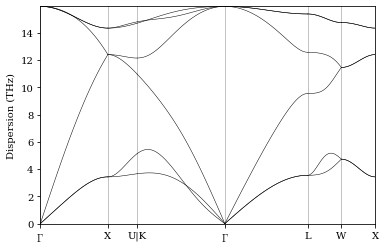

In [5]:
calc.outputs.output_phonopy.phonon_bands.show_mpl()

### Analysing the workflow

Many things happened for computing this phonon band structure. Let's inspect the process tree.

In [6]:
%verdi process status {calc.pk}

PhononWorkChain<100> Finished [0] [7:if_(should_run_phonopy)(1:inspect_phonopy)]
    ├── generate_preprocess_data<101> Finished [0]
    ├── get_supercell<103> Finished [0]
    ├── create_kpoints_from_distance<105> Finished [0]
    ├── PwBaseWorkChain<108> Finished [0] [3:results]
    │   ├── PwCalculation<111> Finished [0]
    │   └── PwCalculation<119> Finished [0]
    ├── get_supercells_with_displacements<125> Finished [0]
    ├── PwBaseWorkChain<128> Finished [0] [3:results]
    │   ├── PwCalculation<131> Finished [0]
    │   └── PwCalculation<139> Finished [0]
    ├── generate_phonopy_data<146> Finished [0]
    └── PhonopyCalculation<148> Finished [0]


Here the explanation:

1. First a {{ preprocess_data }} was instantiated. This data type stores the information of the structure, its symmetries and the displacements dataset to perform for the harmonic phonons.
2. A _base_ ground-state calculation is performed via a {{ pwbase }}. This will be used in the following as _starting point_ for all the structures with displacements.
3. The `StructureData` with displacements are generated.
4. For each of such structures, an SCF is run using a {{ pwbase }} to compute the forces.
5. A {{ phonopy_data }} is generated. This gathers together ALL the information of a phonon calculation: structure, symmetry, supercell, primitive cell, displacements, and forces. (eventually, also the non-analytical constants; see the [tutorial on polar materials](4_polar.ipynb))
6. This data node is used to post-process the information via a {class}`~aiida_phonopy.calculations.phonopy.PhonopyCalculation`.

::: {admonition} Can you explain why only one displacement?
:class: hint, dropdown

We used symmetries to reduce the number of structure with displacements to compute. In materials, we can exploit the fact that different operations are connected by symmetry. As an example, if we have inversion symmetry, it holds (for a one dimensional function):

\begin{equation}
 f(x) = -f(-x)
\end{equation}

Thus, in equation (1) we would save one calculation. In silicon, we have only one atom symmetrically inequivalent, and only one inequivalent direction. The power of group symmetries!
:::

You can also inspect this data to convince yourself.

In [7]:
calc.outputs.phonopy_data.displacement_dataset

{'natom': 8,
 'first_atoms': [{'number': 0,
   'displacement': [0.01, 0.0, 6.123233995736852e-19]}]}

## Final considerations

We managed to compute the phonons of silicon __fully__ ___ab initio___! :tada:

:::{admonition} Learn more and in details
:class: hint

To learn the full sets of inputs, to use proficiently the `get_builder_from_protocol` and more, have a look at the following sections:
- [Specific how tos](howto/workflows/phonons/base.md)
- [General information of the implemented workchain](topics/workflows/phonons/base.md)